Alunos: Daniel de Paula, Gustavo Guerreiro e Mayara Cardoso Simões

# Trabalho Final de Aprendizado de Máquina sobre Visão Computacional: Classificação de Imagens de Cães e Gatos

O dataset utilizado é de propriedade da Microsoft e está disponível em: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

## Separação dos Dados em Treino, Teste e Validação

A primeira etapa da implementação é a de separação dos dados. Inicialmente o diretório se encontra no formato:
```
PetImages/
├── Cat
└── Dog
```

Como uma Rede Neural necessita de uma separação entre treino, teste e possivelmente validação, o GeneratorBasedBuilder irá carregar os dados logicamente com a seguinte estrutura:
```
dataset/
├── train/
│   ├── Cat/
│   └── Dog/
├── val/
│   ├── Cat/
│   └── Dog/
└── test/
    ├── Cat/
    └── Dog/
```
Para usar essa estrutura se utilizou a classe GeneratorBasedBuilder do TensorFlow para fazer a divisão mais eficiente e monstar a estrutura em treino, validação e teste.

## Importação das bibliotecas

In [61]:
from os import path
from glob import glob
from random import Random
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow_datasets.core import GeneratorBasedBuilder, DatasetInfo, Version

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Definição da Classe do Dataset

Para organizar o dataset de uma forma mais eficiente foi criada a classe CatsDogs.
Inicialmente se tem uma função auxiliar chamada listar_imagens_validas, ela é usada para checar se a imagem sendo tratada é de fato um jpg válido ou foi corrompido.

Já a classe CatsDogs em si possui três métodos:
* _info: contém as informações contidas no dataset, no caso uma imagem de 3 dimensões (altura, largura e cor RGB) e o rótulo podendo ser "Cat" ou Dog.
* _split_generators: método principal que busca nas pastas as imagens dos gatos e cães, separa cada grupo em treino, validação e teste e então junta as imagens de cada animal.
* _generate_examples: usado para gerar os dados retornados em si, pegando cada imagem e atribuindo um id para ela.

In [62]:
def listar_imagens_validas(pasta, label):
    caminhos = glob(f"{pasta}/*")
    validos = []
    for caminho in caminhos:
        try:
            with Image.open(caminho) as img:
                formato = img.format
                img.verify()
                if formato == "JPEG":
                    validos.append((caminho, label))
        except (IOError, UnidentifiedImageError, SyntaxError):
            pass
    return validos


class CatsDogs(GeneratorBasedBuilder):
    VERSION = Version("1.0.0")
    SEED = 42
    PASTA_PADRAO = "PetImages"

    def _info(self):
        return DatasetInfo(
            builder=self,
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(shape=(None, None, 3)),
                "label": tfds.features.ClassLabel(names=["Cat", "Dog"]),
            })
        )

    def _split_generators(self, dl_manager):
        raiz = self.PASTA_PADRAO

        gatos = listar_imagens_validas(f"{raiz}/Cat", 0)
        caes = listar_imagens_validas(f"{raiz}/Dog", 1)

        gatos_treino, gatos_resto = train_test_split(gatos, test_size=0.3, random_state=self.SEED)
        gatos_val, gatos_test = train_test_split(gatos_resto, test_size=0.5, random_state=self.SEED)

        caes_treino, caes_resto = train_test_split(caes, test_size=0.3, random_state=self.SEED)
        caes_val, caes_test = train_test_split(caes_resto, test_size=0.5, random_state=self.SEED)

        rng = Random(self.SEED)
        treino = gatos_treino + caes_treino
        rng.shuffle(treino)

        val = gatos_val + caes_val
        rng.shuffle(val)

        teste = gatos_test + caes_test
        rng.shuffle(teste)

        return {
            "train": self._generate_examples(treino),
            "val": self._generate_examples(val),
            "test": self._generate_examples(teste)
        }

    def _generate_examples(self, arquivos):
        for caminho, rotulo in arquivos:
            if not path.isfile(caminho):
                continue
            yield caminho, {"image": caminho, "label": rotulo}


## Instanciamento dos Datasets
A classe CatsDogs é instanciada e os datasets são construídos, baixados e carregados em variáveis.

In [63]:
builder = CatsDogs()
builder.download_and_prepare()

ds_train = builder.as_dataset(split="train")
ds_val = builder.as_dataset(split="val")
ds_test = builder.as_dataset(split="test")

## Pré-Processamento
As imagens são pré processadas, tendo inicialmente o seu tamanho ajustado e então os seus valores normalizados do formato RGB ($[0, 255]$, $[0, 255]$, $[0, 255]$) para o formato padrão esperado pelo MobileNetV2.

In [64]:
TAMANHO = 224

def preprocessamento(dicionario):
    image = dicionario["image"]
    label = dicionario["label"]
    image = tf.image.resize(image, (TAMANHO, TAMANHO))
    image = preprocess_input(image)

    return image, label

Além de aplicar o pré-processamento, os dados são organizados para serem divididos em batches para facilitar o processamento na rede e o prefetch para agilizar o processo de carregamento dos batches enquanto a rede é treinada.

In [65]:
BATCH = 32
ds_train = ds_train.map(preprocessamento).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocessamento).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocessamento).batch(BATCH).prefetch(tf.data.AUTOTUNE)

## Construção do Modelo
Utilizando a arquitetura da rede neural MobileNetV2, congelamos o conhecimento da rede e aplicamos na construção do nosso modelo o chamando de backbone pois trata-se do processamento principal na rede convolucional.

In [66]:
backbone = tf.keras.applications.MobileNetV2(
    input_shape=(TAMANHO, TAMANHO, 3),
    include_top=False,
    weights='imagenet'
)

backbone.trainable = False

O data augmentation é configurado de modo a realizar as seguintes operações:
* Inverter as imagens horizontalmente.
* Rotacionar a imagem levemente.
* Aplicar um pequeno zoom na imagem.

In [67]:
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

Construção do modelo em si, usando uma forma sequencial seguindo as seguintes etapas:
* Definição da camada de input, recebendo uma imagem de tamanho (224,224,3). A última dimensão sendo a das cores.
* Aplicação do data augmentation.
* Aplicação das camadas do backbone da MobileNetV2.
* Achatamento dos resultados com o GlobalAveragePooling2D.
* Aplica um dropout de 20% para evitar overfitting.
* Finalmente tudo se junto na últica camada com um neurônio sigmoid que terá uma valor de 0 a 1. Sendo que se for > 0.5 será considerado cachorro, senão, gato.

In [68]:
def construir_modelo():
    modelo = models.Sequential([
        layers.Input(shape=(TAMANHO, TAMANHO, 3)),
        data_augmentation,
        backbone,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return modelo

## Treinamento

Para que o treino não dure mais do que o necessário, e não se use mais épocas do que preciso, criou-se uma função para obter um early stopping, desse forma a partir do momento que a métrica de val_loss não avança por muitas épocas, o treinamento é sumariamente interrompido.

In [69]:
def obter_early_stopping(paciencia):
    return EarlyStopping(
        monitor='val_loss',
        patience=paciencia,
        verbose=1,
        restore_best_weights=True
    )

O modelo é inicialmente treinado, esse treino inicial tem como objetivo treinar apenas o novo cabeçalho (as camadas Dense e Dropout), enquanto o backbone (MobileNetV2) permanece congelado..

In [ ]:
modelo = construir_modelo()
historico = modelo.fit(
    ds_train,
    validation_data=ds_val,
    epochs=35,
    callbacks=[obter_early_stopping(3)],
)
epochs_fase_1 = len(historico.history['loss'])

Epoch 1/35
219/542 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.7429 - loss: 0.5321

Em uma segunda etapa, as 10 camadas finais (ou do topo) do backbone são descongeladas e inseridas no treino, dessa forma aprimorando os pesos após a extração inicial das características.

In [35]:
backbone.trainable = True

for layer in backbone.layers[:-10]:
    layer.trainable = False

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Após o descongelamento das camadas, o treinamento continua a partir da última época do treinamento de extração de características.

In [36]:
historico_fine_tune = modelo.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    initial_epoch=epochs_fase_1,
    callbacks=[obter_early_stopping(5)]
)

Epoch 21/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 178s 320ms/step - accuracy: 0.9154 - loss: 0.2676 - val_accuracy: 0.9790 - val_loss: 0.0631
Epoch 22/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 188s 294ms/step - accuracy: 0.9395 - loss: 0.1783 - val_accuracy: 0.9699 - val_loss: 0.0926
Epoch 23/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 153s 282ms/step - accuracy: 0.9572 - loss: 0.1224 - val_accuracy: 0.9709 - val_loss: 0.0953
Epoch 24/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 218s 402ms/step - accuracy: 0.9635 - loss: 0.1056 - val_accuracy: 0.9763 - val_loss: 0.0820
Epoch 25/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 238s 358ms/step - accuracy: 0.9652 - loss: 0.0948 - val_accuracy: 0.9820 - val_loss: 0.0635
Epoch 26/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 210s 387ms/step - accuracy: 0.9663 - loss: 0.0892 - val_accuracy: 0.9857 - val_loss: 0.0517
Epoch 27/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 143s 263ms/step - accuracy: 0.9689 - loss: 0.0853 - val_accuracy: 0.9860 - val_loss: 0.0442
Epoch 28/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 218s 403ms/step - accuracy: 

## Avaliando Modelo

Nesta etapa utiliza-se o Scikit Learn para calcular a acurácia e os outros valores de precisão.

In [37]:
y_true = np.concatenate([y for x, y in ds_test], axis=0)

predictions = modelo.predict(ds_test)
y_pred = (predictions > 0.5).astype(int)

target_names = builder.info.features['label'].names

print("--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=target_names))

print(f"Acurácia Geral: {accuracy_score(y_true, y_pred):.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 39s 316ms/step
--- Relatório de Classificação ---
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1861
         Dog       0.99      0.99      0.99      1855

    accuracy                           0.99      3716
   macro avg       0.99      0.99      0.99      3716
weighted avg       0.99      0.99      0.99      3716

Acurácia Geral: 0.9911


Enfim se usa o Seaborn com MatPlotLib para gerar a matriz de confusão.

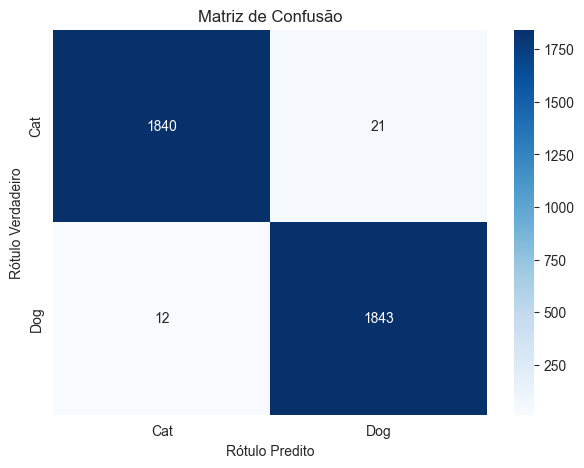

In [38]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Salvando o Modelo

O modelo gerado é salvo em um arquivo na mesma pasta do código fonte.

In [40]:
ARQUIVO_MODELO = 'cats_dogs_model.keras'

modelo.save(ARQUIVO_MODELO)